# Data Engineer Nanodegree

## Capstone project: Financial companies complaints analysis


### Task: Complaints Text Classification 

#### 00. Prepare environment

The first step is the is to prepare the Python + Jupyter Notebooks environment to run the various models. To develop this project I consider several libraries that help us to explore, process, train and validate our data and models.

#### 01. Data Collection 

After understanding the problem at hand, that I proposed to respond by considering the methodology. Then I proceed with the first step of collecting and loading the data into our platform.

The purpose of this notebook, is related to the collection and storage of data so that they can be worked on in a next stage of exploration (It is not our concern in this notebook to explore the data, that I'll leave for notebook 03 - Data Exploration)

For this project I'll use a dataset called Consumer Complaint Database.
These are real world complaints received about financial products and services. Each complaint has been labeled with a specific product; therefore, this is a supervised text classification problem. With the aim to classify future complaints based on its content, I used different ML algorithms can make more accurate predictions (i.e., classify the complaint in one of the product categories).

This set of complaints data is made from a single file, and I can read it using pandas.

**Step 1 - Importing packages**

In [1]:
# General:
import pandas as pd
import numpy as np
import os
import re
import pickle
import subprocess

try:
    from stop_words import get_stop_words
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", 'stop-words'])
finally:
    from stop_words import get_stop_words

## Clean Text
try:
    from cleantext import clean
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", 'clean-text'])
finally:
    from cleantext import clean

## Clean Text
try:
    import sweetviz as sv
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", 'sweetviz'])
finally:
    import sweetviz as sv
    
    


#Seed - https://www.mikulskibartosz.name/how-to-set-the-global-random_state-in-scikit-learn/
seed = 90 #np.random.seed(31415)


# Pre-Processing
from sklearn.preprocessing import LabelEncoder

from stop_words import get_stop_words
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
# Classifiers
from sklearn import model_selection
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC

# Metrics to score classifiers
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve, log_loss

# Data splitting, CV
from sklearn.model_selection import train_test_split,cross_val_score, KFold, StratifiedKFold


# EDA
import sweetviz as sv

# Ploting
import matplotlib.pyplot as plt
import seaborn as sns



# My libraries:
import sys
sys.path.insert(0, '../../src')
sys.path.insert(0, '../../src/utils/')

from utils.helpers import download, convert_json_to_csv, split_csv, save_pickle


# Warnings:
import warnings; warnings.simplefilter('ignore')

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


**Step 2 - Define URL and Folder Destination**

In [2]:
dest_folder = '../data/source'
url = "https://files.consumerfinance.gov/ccdb/complaints.csv.zip"

**Step 3 - Downloading and store the file**

In [3]:
data_file = download(url, dest_folder, unzip=1)

The complaints.csv.zip file exist in ../data/source folder (../../data/source/complaints.csv.zip).


**Step 4 - File and data validation**

In [4]:
# Load dataset with pandas to a variable
df_complaints = pd.read_csv(data_file);
print("Complaints data read successfully!")

Complaints data read successfully!


In [5]:
df_complaints.shape

(2021440, 18)

In a first analysis the data set has a structure of 18 columns and about 1.8 million records.

In [6]:
# print out the first transpose row of data info
df_complaints.head(1).T

,0
Date received,2019-09-24
Product,Debt collection
Sub-product,I do not know
Issue,Attempts to collect debt not owed
Sub-issue,Debt is not yours
Consumer complaint narrative,transworld systems inc. \nis trying to collect...
Company public response,NaN
Company,TRANSWORLD SYSTEMS INC
State,FL
ZIP code,335XX


### 02. Data Exploration and Visualisation

The first step in working with the data set is to load the data and identify what information is included in the data set. This is an important step to eventually work with this data, and to know what kind of characteristics I have to work with when transforming and grouping the data!

In this way, I prepare this notebook to do all the data exploration and pattern observation on the features given to it and the data distribution, as well as the definition of our final data set, to be worked on in the next step of pre-processing and data feature engineering.

#### Exploratory Data Analysis (EDA)
With resources from different EDA and data Pre-Processing methodologies and libraries, I'll explore and visualise this data from the existing data set and analyse the possible metrics that will be used to understand the solution to the problem I propose to answer. Thus, I'll try to identify the relationship between each of the characteristics and features of the complaint.

I'll analyse:
* A general statistical summary of the data set, using EDA visualization tools
* Distribution of `complaints`, `product`, `sub_product`, `issue` and `sub_issue`
* Relationship of complaint text length and assigned product
* Relationship of the complaint narrative to the product allocated
* Relationship of the words of the complaint to the product
* Try to identify the relationship between the features
* I'll try to reduce our data subset

In [7]:
df_complaints.head(2).T

,0,1
Date received,2019-09-24,2019-09-19
Product,Debt collection,"Credit reporting, credit repair services, or o..."
Sub-product,I do not know,Credit reporting
Issue,Attempts to collect debt not owed,Incorrect information on your report
Sub-issue,Debt is not yours,Information belongs to someone else
Consumer complaint narrative,transworld systems inc. \nis trying to collect...,NaN
Company public response,NaN,Company has responded to the consumer and the ...
Company,TRANSWORLD SYSTEMS INC,Experian Information Solutions Inc.
State,FL,PA
ZIP code,335XX,15206


**Step 3 - A few general statistics about dataset**

I'll analyze here the high-level statistics of the complaint

In [8]:
df_complaints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2021440 entries, 0 to 2021439
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memory usage: 277.

I find that there are many records to be found, particularly in the narrative of the complaint. This attribute is very important for our project.

Therefore, I'll have to filter all the complaints that do not have a narrative, because they do not interest us.

In [9]:
# Convert int to string
def to_str(var):
    return str(list(np.reshape(np.asarray(var), (1, np.size(var)))[0]))[1:-1];

In [10]:
# Percentage of columns with text
complaints_with_narrative = df_complaints['Consumer complaint narrative'].notnull().sum()
sub_product_with_text = df_complaints['Sub-product'].notnull().sum()
issue_with_text = df_complaints['Issue'].notnull().sum()
product_with_text  = df_complaints['Product'].notnull().sum()
sub_issue_with_text = df_complaints['Sub-issue'].notnull().sum()

print('Consumer complaint narrative % : ' + to_str(round((complaints_with_narrative/len(df_complaints)*100),1)));
print('Sub-product % : ' + to_str(round((sub_product_with_text/len(df_complaints)*100),1)));
print('Sub-issue % : ' + to_str(round((product_with_text/len(df_complaints)*100),1)));
print('Issue % : ' + to_str(round((issue_with_text/len(df_complaints)*100),1)));
print('Product % : ' + to_str(round((sub_issue_with_text/len(df_complaints)*100),1)));

Consumer complaint narrative % : 34.0
Sub-product % : 88.4
Sub-issue % : 100.0
Issue % : 100.0
Product % : 70.0


Analysing the above metrics, one realizes that the data set is considerably large to work locally. I'll have to filter the data set in some way so that I can explore and train it.

After analysis and taking into account the problem I have proposed, I'll select only the columns that interest us and I'll rename them, considering a new monenclature. The data set contains several characteristics that will not be necessary to solve the classification problem I propose to do. So, for a better analysis and understanding of the text classification problem, I'll build a new data set with fewer columns and with a new sorting.

Data set considering

In [11]:
# rename the columns considered
df_complaints = df_complaints.rename(index=str, columns={"Product": "product", "Sub-product": "sub_product", "Issue": "issue", "Sub-issue": "sub_issue", "Consumer complaint narrative": "complaint_text", "Complaint ID": "complaint_id", "Company": "company"})

# Create a new dataframe with 6 columns
df_complaints = df_complaints[['complaint_id', 'complaint_text', 'issue', 'sub_issue','product', 'sub_product', 'company']].copy()

# new column for understand lenght of complaint_text - I have situations where there are no narratives.
df_complaints['complaint_text_length'] = df_complaints['complaint_text'].str.len()

df_complaints.head(3)

,complaint_id,complaint_text,issue,sub_issue,product,sub_product,company,complaint_text_length
0,3384392,transworld systems inc. \nis trying to collect...,Attempts to collect debt not owed,Debt is not yours,Debt collection,I do not know,TRANSWORLD SYSTEMS INC,98.0
1,3379500,NaN,Incorrect information on your report,Information belongs to someone else,"Credit reporting, credit repair services, or o...",Credit reporting,Experian Information Solutions Inc.,NaN
2,3433198,"Over the past 2 weeks, I have been receiving e...",Communication tactics,Frequent or repeated calls,Debt collection,I do not know,"Diversified Consultants, Inc.",395.0


In [12]:
df_complaints = df_complaints[pd.notnull(df_complaints['complaint_text'])]

In [13]:
df_complaints.shape

(688151, 8)

I have reduced data set in 60%.

In [14]:
# Remove % of data in dataframe    
def reduce_dataset(df, column: str, value: str,  frac: float):
    """ this function recive a input dataset and based on column and value reduce this same data set by fraction sample
        df: a dataframe
        column: a string
        value: 
        frac: value to delete
        return: modified initial dataframe without % of data based on column and value
    """    
    try:
        df = \
            df.drop(
            df[df[column] == value].sample(frac=frac).index)
        
        return df
    
    except:
        return df;

In [15]:
# Percentage of columns with text
complaints_with_narrative = df_complaints['complaint_text'].notnull().sum()
print('Complaint Narrative with text %: ' + to_str(round((complaints_with_narrative/len(df_complaints)*100),1)));

Complaint Narrative with text %: 100.0


In [16]:
df_complaints.shape

(688151, 8)

In the next cell, print out some statistics about the length of text

In [17]:
df_complaints['log_length'] = df_complaints.complaint_text_length.apply(np.log2)

In [18]:
print('Metrics for Complaint Text length')
print('---')
print(f'Mean: {df_complaints.complaint_text_length.mean():.2f}')
print(f'Median: {df_complaints.complaint_text_length.median():.0f}')
print(f'Max: {df_complaints.complaint_text_length.max()}')
print(f'90th Percentile: {df_complaints.complaint_text_length.quantile(.9):.0f}')
print(f'95th Percentile: {df_complaints.complaint_text_length.quantile(.95):.0f}')

Metrics for Complaint Text length
---
Mean: 1065.49
Median: 702
Max: 32317.0
90th Percentile: 2287
95th Percentile: 3214


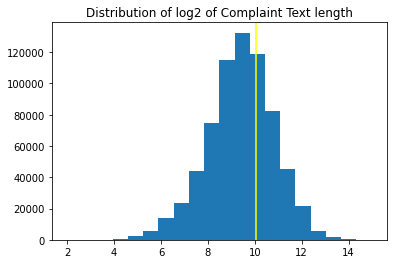

In [19]:
plt.hist(df_complaints.log_length,bins=20);
plt.title('Distribution of log2 of Complaint Text length')
plt.axvline(x=np.log2(df_complaints.complaint_text_length.mean()),color='yellow');

In [20]:
df_complaints.complaint_text_length.quantile(.95)

3214.0

n the next cell, print out some statistics about the data.

In [21]:
# print out some stats about the data
print('Number of complaints: ', df_complaints.shape[0])  # .shape[0] gives the rows 
# .unique() gives unique items in a specified column
print('Number of unique products: ', (len(df_complaints['product'].unique())))
print('Unique complaint products: ', (df_complaints['product'].unique()))

Number of complaints:  688151
Number of unique products:  18
Unique complaint products:  ['Debt collection'
 'Credit reporting, credit repair services, or other personal consumer reports'
 'Money transfer, virtual currency, or money service' 'Mortgage'
 'Vehicle loan or lease' 'Student loan' 'Credit card or prepaid card'
 'Checking or savings account' 'Credit card'
 'Payday loan, title loan, or personal loan' 'Consumer Loan' 'Payday loan'
 'Credit reporting' 'Money transfers' 'Other financial service'
 'Bank account or service' 'Prepaid card' 'Virtual currency']


The aim is to try to predict through classification what product I can assign to a complaint. So these two columns are really important for this project.

Since our classification label is the product, it's important to understand it's distribution and balancing.

When I have certain high levels of balancing, that is, when a large % of the complaints are classified for number of products, I may have some problems in the accuracy of the models, because it can be high for this same reason.

To what extent is our data evenly distributed among the different products and complaint levels?

Our data set is quite large, especially with regard to examples of different product levels. The data is distributed slightly unbalanced.

In [22]:
# Show counts by different products and sub product of complaints

# group and count by product
counts_per_product=df_complaints.groupby(['product']).size().reset_index(name="Counts")
print("\nProduct:")
display(counts_per_product)

# group by sub product
counts_per_sub_product=df_complaints.groupby(['sub_product']).size().reset_index(name="Counts")
print("\nSub Product:")
display(counts_per_sub_product)

# group by product and sub product
counts_complaints_products=df_complaints.groupby(['product', 'sub_product']).size().reset_index(name="Counts")
print("\nProduct & Sub Product :")
display(counts_complaints_products)


Product:


,product,Counts
0,Bank account or service,14885
1,Checking or savings account,29955
2,Consumer Loan,9472
3,Credit card,18838
4,Credit card or prepaid card,51191
5,Credit reporting,31588
6,"Credit reporting, credit repair services, or o...",252634
7,Debt collection,136178
8,"Money transfer, virtual currency, or money ser...",13258
9,Money transfers,1497



Sub Product:


,sub_product,Counts
0,(CD) Certificate of deposit,274
1,Auto,1064
2,Auto debt,3622
3,CD (Certificate of Deposit),497
4,Cashing a check without an account,134
...,...,...
70,Traveler’s/Cashier’s checks,22
71,VA mortgage,4832
72,Vehicle lease,961
73,Vehicle loan,5141



Product & Sub Product :


,product,sub_product,Counts
0,Bank account or service,(CD) Certificate of deposit,274
1,Bank account or service,Cashing a check without an account,134
2,Bank account or service,Checking account,10113
3,Bank account or service,Other bank product/service,3477
4,Bank account or service,Savings account,887
...,...,...,...
90,Vehicle loan or lease,Lease,2252
91,Vehicle loan or lease,Loan,10225
92,Vehicle loan or lease,Title loan,14
93,Virtual currency,Domestic (US) money transfer,15


I can see that the products follow an unbalanced distribution, because there are 2 or 3 products that fit more complaints.

<BarContainer object of 18 artists>

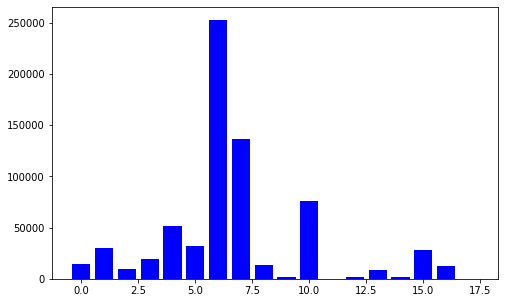

In [23]:
# counts
group = ['product']
counts = df_complaints.groupby(group).size().reset_index(name="Counts")

%matplotlib inline
plt.figure(figsize=(8,5))
plt.bar(range(len(counts)), counts['Counts'], color = 'blue')

Through the analysis I find that the number of complaints per product is unbalanced. The complaints are more focused on `creadit reporting`, `debt collection` and `mortgages`.

Some algorithms are often biased towards the majority class, not taking into account the distribution of data. Often the minority classes are treated as outliers and can easily be ignored.

There are 18 different product classes. However; It's observed that some classes are contained in others. For instance, `Credit card` and `Prepaid card` are contained in `Credit card or prepaid card` product. 
If have a new complaint about Credit card and I want to classify it, the algorithm can either classify this complaint as `Credit card` or `Credit card or prepaid` and it would be correct, but this would affect model performance. In order to avoid this problem, the names of some products were mapping to another product . I'll try to consolidate some of these products, joining the products with multiple or repeated descriptions (there are several products of `Loan`, `Credit Card`, `Prepaid`, `Payday`, etc...).

Even so, I'll have product with more proipherance, which may even be reasonable as they may allow us a greater accuracy.

Let's have a look at the products:

In [24]:
# Number of Complaints in each Product
product_balanced = (df_complaints.groupby('product').size()).sort_values(ascending = False)
print(product_balanced)

product
Credit reporting, credit repair services, or other personal consumer reports    252634
Debt collection                                                                 136178
Mortgage                                                                         75796
Credit card or prepaid card                                                      51191
Credit reporting                                                                 31588
Checking or savings account                                                      29955
Student loan                                                                     27849
Credit card                                                                      18838
Bank account or service                                                          14885
Money transfer, virtual currency, or money service                               13258
Vehicle loan or lease                                                            12491
Consumer Loan                      

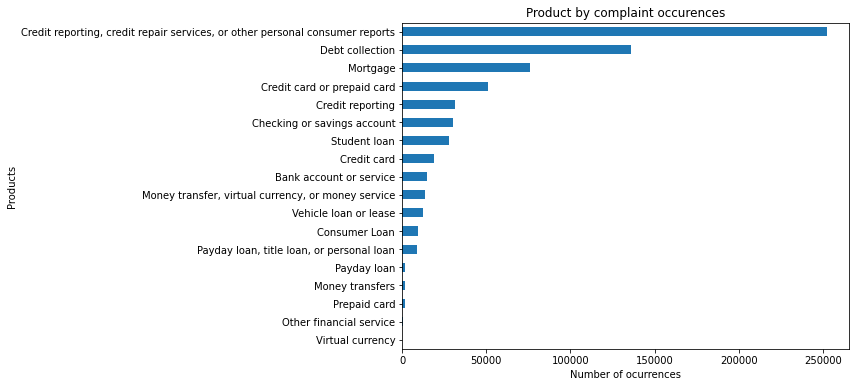

In [25]:
# Number of Complaints in each Product
fig = plt.figure(figsize=(8,6))
df_complaints.groupby('product').complaint_text.count().sort_values().plot.barh(ylim=0, title='Product by complaint occurences');
plt.xlabel('Number of ocurrences', fontsize = 10);
plt.ylabel('Products', fontsize = 10);
plt.show();

Since this is a stage of exploration, I don't seek to make major changes in our data set, I'll leave this work to the next phase. In the next phase of the project I'll prepare our final dataset, and for that I'll consider the following consolidation of the products:

* 'Credit reporting, credit repair services, or other personal consumer reports’ --> 'Credit reporting, repair, or other'
* 'Credit reporting': 'Credit reporting, repair, or other'
* 'Credit card' --> 'Credit card or prepaid card'
* 'Prepaid card' --> 'Credit card or prepaid card'
* 'Money transfer' --> 'Money transfer, virtual currency, or money service'
* 'Virtual currency' --> 'Money transfer, virtual currency, or money service'
* 'Payday loan, title loan, or personal loan' -->'Loan',
* 'Student loan' --> 'Loan'
* 'Consumer Loan' -->'Loan'
* 'Payday loan' -->'Loan'
* 'Vehicle loan or lease' --> 'Loan'

**Step 6 - Looking at a sample text**

When analysing examples of complaints I realise that it's complicated to read, because you have lots of characters and they are too long texts.

This text can be worked on, with to pre-processing techniques. I can remove the special characters, put the text in small letters, remove the numbers, vectorize, summarize the texts, etc.

In [26]:
# Create at a sample text
complaint_text = list(df_complaints.complaint_text[:3])[2]

# Converting to a list for TfidfVectorizer to use
list_sample_complaint_text = []
list_sample_complaint_text.append(complaint_text)
list_sample_complaint_text 

['i, XXXX XXXX XXXX, woman of flesh and blood, beneficiary to the account XXXX XXXX XXXX ssn : XXXX dob : XX/XX/1992 previous address XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX NV XXXX [ zip code exempt ] current living address XXXX XXXX XXXX XXXX XXXX XXXX, NV XXXX [ zip code exempt ], new mailing address XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX NV XXXX [ zip code exempt ] have submitted several disputes to Equifax through the CFPB as well as USPS but have received no results and it has now been well over 30 days. \n\nI received a letter by mail from Equifax stating that they received my request concerning my Equifax credit file but that they could not locate my file. That it may be due to me not having a current file, or not applying for credit recently, or that i have not actively used credit in ten years. However when I logged into Equifax I was able to find my credit file. Is there a reason why you were unable to find my credit file but I am able to? Also out of the two scores present

In [27]:
# Observing what words are extracted from a TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer;

TfidfVectorizer = TfidfVectorizer(stop_words='english', sublinear_tf=True);

check_TfidfVectorizer = TfidfVectorizer.fit_transform(list_sample_complaint_text);
#check_TfidfVectorizer = TfidfVectorizer.fit_transform(helpers.clean_text(list_sample_complaint_text))

print(TfidfVectorizer.get_feature_names());

['1992', '30', 'able', 'account', 'action', 'actively', 'address', 'affecting', 'allowed', 'applying', 'attempt', 'behalf', 'believe', 'beneficiary', 'blood', 'cfpb', 'chosen', 'clearly', 'code', 'concerning', 'connected', 'continue', 'corporation', 'corporations', 'correct', 'credit', 'current', 'days', 'destroy', 'dispute', 'disputes', 'dob', 'documents', 'equifax', 'exempt', 'extort', 'false', 'file', 'flesh', 'having', 'identity', 'investigate', 'lawful', 'leads', 'letter', 'living', 'locate', 'locating', 'logged', 'mail', 'mailing', 'money', 'new', 'numbers', 'nv', 'payment', 'people', 'presented', 'previous', 'proof', 'provide', 'provided', 'reason', 'received', 'receiving', 'recently', 'refusing', 'request', 'results', 'score', 'scores', 'ssn', 'state', 'statement', 'stating', 'submitted', 'taken', 'unable', 'used', 'usps', 'way', 'woman', 'working', 'xx', 'xxxx', 'years', 'zip']


I can rely on stop_word removal from tfidf. Through the tests, I see that it removes the punctuations and also all stop words. 
Therefore, I'll try to use tfidf as it is, but probably I'll apply the cleaning of the text in the next stage  (Text Processing):
1. converting all letters to lower
2. converting numbers into words 
3. removing white spaces
4. expanding some abbreviations
5. removing non ascii
6. remove wrong convertion characters from text
7. removing xxx since it will be treated as importand words by tf-idf vectorization

Do the product use their language? `English`.

#### 03. Data Pre-Preprocessing & Data Feature Enginnering

At this stage of the project, after the data exploration stage where I understand how the data is distributed, I'll work this data set in order to have a final data set for the project. I'll apply here some mechanisms to reduce in the data set, trying to reduce it by 90%, because this is too big to be worked on locally in my laptopt.

After preparing the final dataset, I'll transform the features so that they can be used in our model. This step includes the process of loading dataset and performing basic data exploration and preprocessing. The dataset is then splitted into training and test sets;

I prepared this notebook for the data preparation and feature engineering phase.

In [28]:
# product consolidation
df_complaints['product_consolidation'] = df_complaints['product']

# Renaming products
df_complaints.replace({'product_consolidation': 
             {
                'Credit reporting, credit repair services, or other personal consumer reports': 
                'Credit reporting, repair, or other', 
                'Credit reporting': 'Credit reporting, repair, or other',
                'Credit card': 'Credit card or prepaid card',
                'Prepaid card': 'Credit card or prepaid card',
                'Money transfers': 'Money transfer, virtual currency, or money service',
                'Virtual currency': 'Money transfer, virtual currency, or money service',
                'Payday loan, title loan, or personal loan':'Loan',
                'Student loan': 'Loan',
                'Consumer Loan':'Loan',
                'Payday loan':'Loan',
                'Vehicle loan or lease': 'Loan'}
                }, 
            inplace= True);

In [29]:
# Number of Complaints in each Product
product_consolidation_balanced = (df_complaints.groupby('product_consolidation').size()).sort_values(ascending = False)
print(product_consolidation_balanced)

product_consolidation
Credit reporting, repair, or other                    284222
Debt collection                                       136178
Mortgage                                               75796
Credit card or prepaid card                            71479
Loan                                                   60573
Checking or savings account                            29955
Bank account or service                                14885
Money transfer, virtual currency, or money service     14771
Other financial service                                  292
dtype: int64


<BarContainer object of 9 artists>

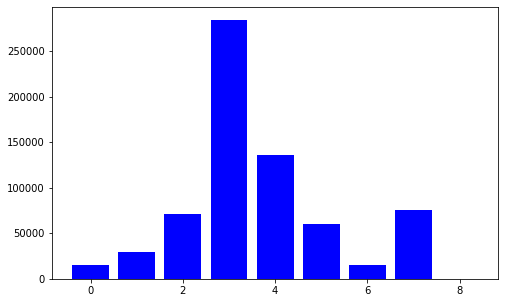

In [30]:
# Product distribution 
group = ['product_consolidation']
counts = df_complaints.groupby(group).size().reset_index(name="Counts")

%matplotlib inline
plt.figure(figsize=(8,5))
plt.bar(range(len(counts)), counts['Counts'], color = 'blue')

In [31]:
#Label-Encoding: It can only be applied to target variable, in this case new variable product_consolidation .
encoder = LabelEncoder();

df_complaints['product_consolidation_label'] = encoder.fit_transform(df_complaints['product_consolidation'])

In [32]:
# Number of Complaints in each Product
product_consolidation_balanced = (df_complaints.groupby('product_consolidation_label').size().sort_values()).sort_values(ascending = False)
print(product_consolidation_balanced)

product_consolidation_label
3    284222
4    136178
7     75796
2     71479
5     60573
1     29955
0     14885
6     14771
8       292
dtype: int64


In [33]:
# Create a new dataframe with 3 important columns
df_complaints_pre_final = df_complaints[['complaint_text', 'product_consolidation', 'product_consolidation_label']]

df_complaints_pre_final = df_complaints_pre_final.rename(index=str, columns={"product_consolidation": "product", "complaint_text": "complaint_text", 'product_consolidation_label':'product_id'})

In [34]:
# Number of Complaints in each Product
product_balanced = (df_complaints_pre_final.groupby('product').size()).sort_values(ascending = False)
print(product_balanced)

product
Credit reporting, repair, or other                    284222
Debt collection                                       136178
Mortgage                                               75796
Credit card or prepaid card                            71479
Loan                                                   60573
Checking or savings account                            29955
Bank account or service                                14885
Money transfer, virtual currency, or money service     14771
Other financial service                                  292
dtype: int64


In [35]:
print('Before reduce dataset ')  
df_complaints_pre_final.shape

Before reduce dataset 


(688151, 3)

In [36]:
# Number of samples in the least represented class
#quota = df_complaints_pre_final['product'].value_counts().mean()
quota = df_complaints_pre_final['product'].value_counts().min()
quota = int(quota)

In [37]:
# New DataFrame to add equal number of samples from each class
balanced_data = pd.DataFrame(columns=['product', 'complaint_text','product_id'])

# Reduce each group to the chosen number of samples
data_groups = df_complaints_pre_final.groupby('product')
for group in data_groups.indices:
    reduced_class = data_groups.get_group(group)[['product', 'complaint_text','product_id']].iloc[:quota, :]
    balanced_data = balanced_data.append(reduced_class, ignore_index=True)

In [38]:
 # Class distribution in the new dataset
balanced_data['product'].value_counts()

Credit reporting, repair, or other                    292
Money transfer, virtual currency, or money service    292
Mortgage                                              292
Debt collection                                       292
Other financial service                               292
Credit card or prepaid card                           292
Checking or savings account                           292
Loan                                                  292
Bank account or service                               292
Name: product, dtype: int64

In [39]:
balanced_data

,product,complaint_text,product_id
0,Bank account or service,M & t bank customer service Claims a credit ca...,0
1,Bank account or service,I tried to transfer {$2900.00} to XXXX on XXXX...,0
2,Bank account or service,I own a XXXX wanted to transfer money from XXX...,0
3,Bank account or service,My bank account was tied to my XXXX. My XXXX w...,0
4,Bank account or service,Found RV ( motorhome ) on XXXX interested in p...,0
...,...,...,...
2623,Other financial service,I have a bad experience to DMB financial credi...,8
2624,Other financial service,We signed up for ClearOne Advantage to handle ...,8
2625,Other financial service,"I made a transaction on XXXX XXXX, 2016 on the...",8
2626,Other financial service,I attempted to exchange euros to dollars at th...,8


In [40]:
df_complaints_final=balanced_data

In [41]:
print('After reduce dataset ')  
df_complaints_final.shape

After reduce dataset 


(2628, 3)

In [42]:
df_complaints_final.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2628 entries, 0 to 2627
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   product         2628 non-null   object
 1   complaint_text  2628 non-null   object
 2   product_id      2628 non-null   object
dtypes: object(3)
memory usage: 61.7+ KB


In [43]:
# Function to clean
def clean_text(text, bu):
    if "english" in bu:
        country_code = 'en'
    else:
        country_code = 'en'

    clean_text = clean(text,
                       fix_unicode=True,  # fix various unicode errors
                       to_ascii=True,  # transliterate to closest ASCII representation
                       lower=True,  # lowercase text
                       no_line_breaks=False,  # fully strip line breaks as opposed to only normalizing them
                       no_urls=True,  # replace all URLs with a special token
                       no_emails=True,  # replace all email addresses with a special token
                       no_phone_numbers=True,  # replace all phone numbers with a special token
                       no_numbers=True,  # replace all numbers with a special token
                       no_digits=True,  # replace all digits with a special token
                       no_currency_symbols=False,  # replace all currency symbols with a special token
                       no_punct=True,  # remove punctuations
                       replace_with_punct="",  # instead of removing punctuations you may replace them
                       replace_with_url="",
                       replace_with_email="",
                       replace_with_phone_number="",
                       replace_with_number="",
                       replace_with_digit="",
                       replace_with_currency_symbol="",
                       lang=country_code
                       )

    return clean_text


In [44]:
#df_complaints_final['complaint_text_clean'] = df_complaints_final['complaint_text'].map(lambda x: clean_text(x, 'english'))

In [45]:
df_products = df_complaints_final[['product']]
products = df_complaints_final['product']

df_products_id = df_complaints_final[['product_id']]
products_id = df_complaints_final['product_id']

# Labels
df_labels = df_complaints_final[['product_id', 'product']].drop_duplicates().sort_values(by = 'product_id', ascending = True)
print('------------- PRODUCTS ~ LABELS ------------')
#print(df_products)
print((df_complaints_final.groupby(['product_id', 'product']).size()).sort_values(ascending = False))
print('')

# Dictionaries for labels
print('------------- DIC. PRODUCTS ~ Dic. LABELS ------------')
product_to_id = dict(df_labels.values) # key-value pair
id_to_product = dict(df_labels[['product_id', 'product']].values)  #key-value pair
print('')
print(product_to_id)
print('')
print(id_to_product)
print('')
      
# Features
df_pre_features  = df_complaints_final[['complaint_text']]
pre_features  = df_complaints_final['complaint_text']
print('')
print('------------- COMPLAINTS ~ FEATURES ------------')
print(df_pre_features)
print('')


------------- PRODUCTS ~ LABELS ------------
product_id  product                                           
0           Bank account or service                               292
1           Checking or savings account                           292
2           Credit card or prepaid card                           292
3           Credit reporting, repair, or other                    292
4           Debt collection                                       292
5           Loan                                                  292
6           Money transfer, virtual currency, or money service    292
7           Mortgage                                              292
8           Other financial service                               292
dtype: int64

------------- DIC. PRODUCTS ~ Dic. LABELS ------------

{0: 'Bank account or service', 1: 'Checking or savings account', 2: 'Credit card or prepaid card', 3: 'Credit reporting, repair, or other', 4: 'Debt collection', 5: 'Loan', 6: 'Money transfer,

**Step 5 - Text processing and Split Data**

One of the aim of this project is the construction of a **complaints classifier**. And this task is a comparison text; a text which looks at a given complaint and product text, compares them and predicts whether a complaint has been classified from the product. To make this comparison effective, and train a classifier, I'll  have to do a few more things: 

First, I'll clean pre-process all the complaints narratives to be easily compared with the products:

1. converting all letters to lower
2. converting numbers into words 
3. removing white spaces
4. expanding some abbreviations
5. removing non ascii
6. remove wrong convertion characters from text
7. removing xxx since it will be treated as importand words by tf-idf vectorization

Then I'll divide our data into `train` data and `test` data, so that they can be used to train a classifier and evaluate it, respectively.

The first 80% is training and the last 20% is test set. If we set the shuffle parameter to True, the data will be randomly split:

In [46]:
def split_data(df_x, df_y, is_clean: bool, is_shuffle: bool, seed: int):
    """
    This function allows the split data 
        param df: data set
        param is_clean = to clean?
        param is_shuffle = shuffle split data
        param seed = cross-validation generator or an iterabl k-fold 5.
    """
    # Set the number of testing points
    if is_clean:
        X_all = df_x.map(lambda x: clean_text(x, 'english'))
    else:
        X_all = df_x #features

    y_all = df_y #label
    
    #Set the number of testing points
    if is_shuffle:
        X_train, X_test, y_train, y_test = train_test_split(
                                                X_all, 
                                                y_all, 
                                                test_size=0.2,   # 80% train/cv, 20% test (5 CV)
                                                stratify=y_all,
                                                random_state=seed,
                                                shuffle=True)
        # Shuffle and split the dataset into the number of training and testing points above
    else:
        X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    test_size=0.2,   # 80% train/cv, 20% test
                                                    random_state=seed,
                                                   )
        
    print('X shape:', X_all.shape, 'y shape:', y_all.shape, 'X_train:', X_train.shape, 'y_train:', y_train.shape,'X_test:', X_test.shape, 'y_test:', y_test.shape)

    return  X_train, X_test, y_train, y_test;

In [50]:
# tokenizer words in vectors TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
def tokenize_TfidfVectorizer(X_train, X_test, stop_words, is_bigram:True):
    
    if is_bigram:
        word_vectorizer = TfidfVectorizer(
                            sublinear_tf=True, # set to true to scale the term frequency in logarithmic scale.
                            min_df=5,
                            stop_words=stop_words,
                            #strip_accents='unicode',
                            #token_pattern=r'\w{1,}',
                            #analyzer='word',
                            ngram_range=(1, 2));
    
    else: #only-gram
        
        word_vectorizer = TfidfVectorizer(
                            sublinear_tf=True, # set to true to scale the term frequency in logarithmic scale.
                            min_df=5,
                            stop_words=stop_words,
                            #strip_accents='unicode',
                            #token_pattern=r'\w{1,}',
                            #analyzer='word',
                            ngram_range=(1, 1));

    X_train = word_vectorizer.fit_transform(X_train).toarray()
    X_test = word_vectorizer.transform(X_test)

    return {
        'X_train': X_train,
        'X_test': X_test,
        'word_vectorizer': word_vectorizer
    }

To train supervised classifiers, we first transformed the `complaint_text` into a vector of numbers so that the algorithms to be used are able to make prediction. In this case, the term `Frequency - Reverse Document Frequency (TFIDF)` like bag of words to will be used to assess the importance of a word for a complaint in a complaints collection. As the text is long, the removal of `stop words` is also considered.

After removing the punctuation and remove stop words, the importance of a word is determined in terms of its frequency.

#### 04. Split test and train data

It should return the follow tuples:

* `X_train` `y_train` - selected training features and their corresponding product labels without text clean 

* `X_test` `y_test` - selected training features and their corresponding produt labels without text clean 

* `X_test_clean` and `y_test_clean` - selected training features and their corresponding produt labels with text clean 



In [51]:
is_shuffle=True

# split data with clean text
is_clean=False
X_train, X_test, y_train, y_test = split_data(pre_features, products, is_clean, is_shuffle, seed)


X shape: (2628,) y shape: (2628,) X_train: (2102,) y_train: (2102,) X_test: (526,) y_test: (526,)


In [52]:
### bigram and text clean

is_bigram=True
stop_words='english'

tokens = tokenize_TfidfVectorizer(X_train, X_test, stop_words, is_bigram)
_X_train = tokens['X_train']
_X_test = tokens['X_test']
_word_vectorizer = tokens['word_vectorizer']


### Transform each complaint into a vector

#_pre_features = _word_vectorizer.fit_transform(pre_features).toarray()
#print("Each of the %d complaints is represented by %d features (representing TfidfVectorizer score of bigrams and clean text)" %(_pre_features.shape))
#train.features_correlated(_word_vectorizer,_pre_features, df_products, df_products_id, product_to_id, 5)
#print('-' *30)
#print('-' *30)

#### 05. Evalute Models

The proposed models were trained and based on the above statistics, the two best ones were identified and chosen for evaluation: SVM Linear SVC and Logistic Regression. Precision metric was the metric used to choose these two models.

Below, a report was generated with the statistics obtained by model.

------------------------------
------------------------------
# Model: LogisticRegression
LogisticRegression Model Accuracy Score 73.76425855513308
------------------------------
------------------------------
# Classification Report
                                                    precision    recall  f1-score   support

                           Bank account or service       0.69      0.60      0.64        58
                       Checking or savings account       0.61      0.67      0.64        58
                       Credit card or prepaid card       0.71      0.86      0.78        59
                Credit reporting, repair, or other       0.82      0.71      0.76        59
                                   Debt collection       0.76      0.69      0.73        59
                                              Loan       0.73      0.79      0.76        58
Money transfer, virtual currency, or money service       0.72      0.76      0.74        58
                             

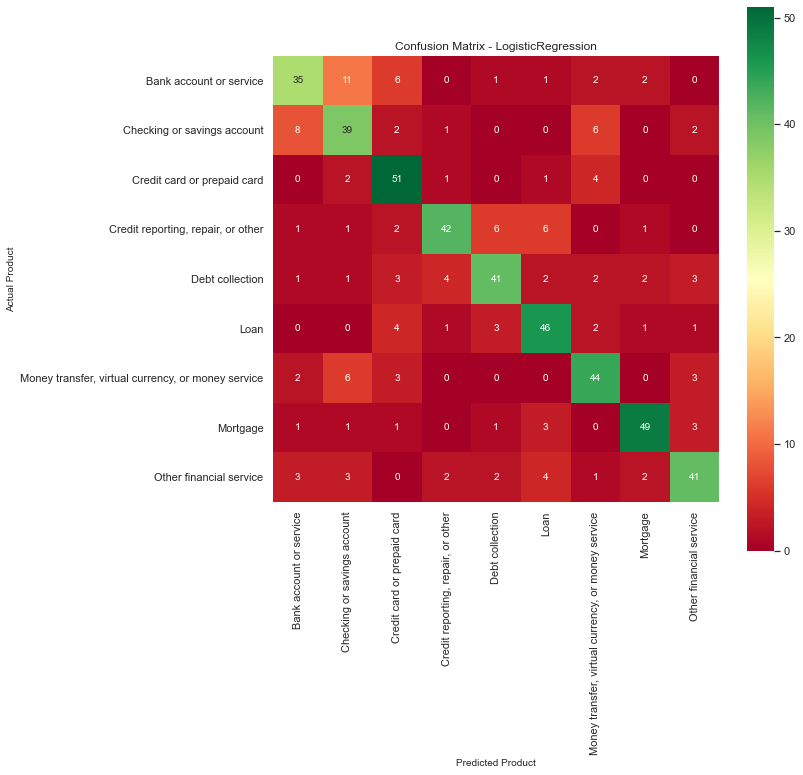

------------------------------
------------------------------
------------------------------
------------------------------
# Model: LinearSVC
LinearSVC Model Accuracy Score 72.43346007604563
------------------------------
------------------------------
# Classification Report
                                                    precision    recall  f1-score   support

                           Bank account or service       0.62      0.55      0.58        58
                       Checking or savings account       0.60      0.67      0.63        58
                       Credit card or prepaid card       0.71      0.83      0.77        59
                Credit reporting, repair, or other       0.76      0.69      0.73        59
                                   Debt collection       0.83      0.68      0.75        59
                                              Loan       0.70      0.78      0.74        58
Money transfer, virtual currency, or money service       0.70      0.74      

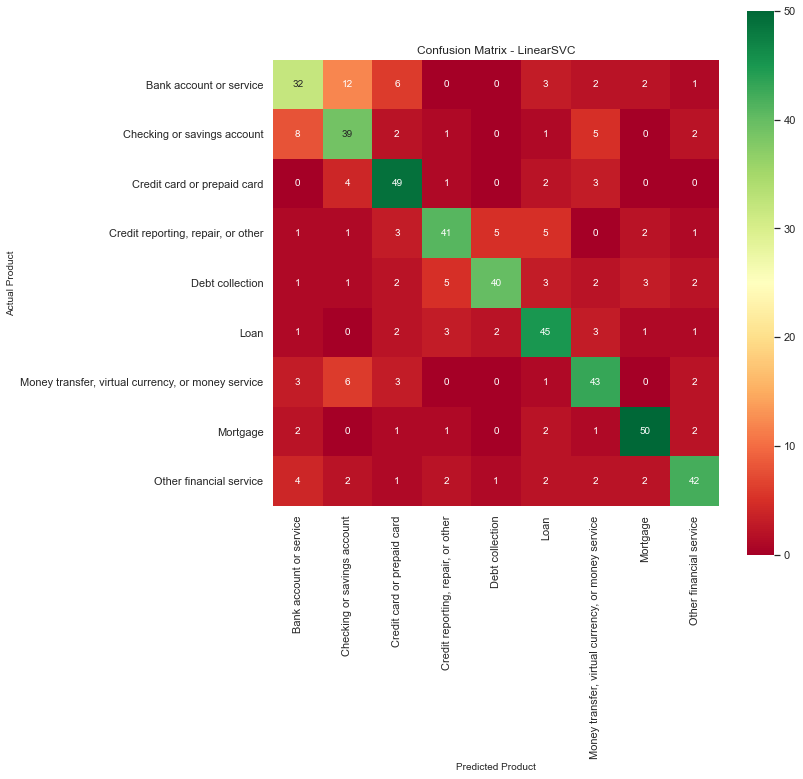

------------------------------
------------------------------


In [53]:
# Classification Report
p = products.drop_duplicates()
p = p.copy()

models = [
        ('LogisticRegression', LogisticRegression(random_state=seed)),
        ('LinearSVC', LinearSVC())
        ]
names = []
for name, model in models:
    model = model.fit(_X_train, y_train)
    y_pred = model.predict(_X_test)
    print("-"*30)
    print("-"*30)
    print("# Model: " + name)
    print(name + ' Model Accuracy Score', accuracy_score(y_test,y_pred)*100)
    print("-"*30)
    print("-"*30)
    print('# Classification Report')
    print(classification_report(y_test, y_pred))
    print("-"*30)
    print("-"*30)
    print('Confusion Matrix for ' + name)
    #print(confusion_matrix(y_test, y_pred))
    conf_mat = confusion_matrix(y_test, y_pred)
    sns.set(font_scale=1)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, annot_kws={"size":10}, cmap="RdYlGn", square=True, fmt='d',
                xticklabels= p.values, yticklabels= p.values)
    plt.ylabel('Actual Product', fontsize = 10)
    plt.xlabel('Predicted Product', fontsize = 10)
    plt.title('Confusion Matrix - '+ name)
    plt.show()
    print("-"*30)
    print("-"*30)
    #plot_precision_recall_curve(model, y_test, y_pred)
    #plt.title('Precision-Recall Curve - '+ name)
    #plt.show()



#### Validate chosen models

After selecting the two best models, I will try to make some tests of the model to see if the behavior is what is expected.

I will create the models and the predictor, to 
make the necessary tests.

After the tests I will save the model to use in the app.


**Logistic Regression Model**

In [54]:
# Initializing our chosen logreg model
LogisticRegression = LogisticRegression(random_state=seed)

# Fitting our model
LogisticRegression_fit = LogisticRegression.fit(_X_train, y_train)

# Obtaining prediction
y_prediction_LogisticRegression = LogisticRegression_fit.predict(_X_test)

print('Logistic Regression Model Accuracy Score', accuracy_score(y_test, y_prediction_LogisticRegression)*100)

Logistic Regression Model Accuracy Score 73.76425855513308


In [55]:
# Create at a sample text
complaint_text = list(df_complaints_final.complaint_text[:3])[2]

# Converting to a list for TfidfVectorizer to use
list_sample_complaint_text = []
list_sample_complaint_text.append(complaint_text)
list_sample_complaint_text 

print(list_sample_complaint_text)
print(LogisticRegression_fit.predict(_word_vectorizer.transform(list_sample_complaint_text)))

["I own a XXXX wanted to transfer money from XXXX banks to Huntington so it was more convenient than my small town banks. Was told to give irs ein which is under my ss # she said no problem we can look it up that way. Now today when I go with everything she asked for, and I have a witness, she said no that even since ein # has been ur ss # since 1998 they demand me to change it ... XXXX!! Huntington you can praise your XXXX Indiana branch for losing you thousands of dollars, but I 'm sure that does n't effect your highway robbery business ... ..pissed as XXXX customer"]
['Bank account or service']


In [56]:
print(LogisticRegression_fit.predict(_word_vectorizer.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

['Debt collection']


**Linear SVC**

In [57]:
# Initializing our chosen logreg model
LinearSVC = LinearSVC(random_state=seed)

# Fitting our model
LinearSVC_fit = LinearSVC.fit(_X_train, y_train)

# Obtaining prediction
y_prediction_LinearSVC = LinearSVC.predict(_X_test)

print('Linear SVC Model Accuracy Score', accuracy_score(y_test, y_prediction_LinearSVC)*100)

Linear SVC Model Accuracy Score 72.43346007604563


In [58]:
print(list_sample_complaint_text)
print(LinearSVC_fit.predict(_word_vectorizer.transform(list_sample_complaint_text)))

["I own a XXXX wanted to transfer money from XXXX banks to Huntington so it was more convenient than my small town banks. Was told to give irs ein which is under my ss # she said no problem we can look it up that way. Now today when I go with everything she asked for, and I have a witness, she said no that even since ein # has been ur ss # since 1998 they demand me to change it ... XXXX!! Huntington you can praise your XXXX Indiana branch for losing you thousands of dollars, but I 'm sure that does n't effect your highway robbery business ... ..pissed as XXXX customer"]
['Bank account or service']


After some tests it turns out that some of the complaints are poorly classified because they address more than one particular issue. Or one can also verify that new complaints that have nothing to do with the financial subject are classified to products that have nothing to do with it.

Regarding the former, these are errors that will normally happen (a complaint can say debit card and loans and is classified for one of them). Regarding the second problem, I can advance that in future work a product can be created ("Others") where these complaints can "enter".

#### Refinement and training Model

Due to the performance challenge of my machine, during the implementation of the models several tests and simulations were carried out, leading to the refinement of the models according to the needs.
New models were defined to train the data set, variations of the models already selected with the use of different parameters and some models were also removed due to performance problems in their execution:

Unbalanced Classes: I have chosen to consolidate the products in other products classes.

Bag of Words: To create the bag of words, I considered TfidfVectorizer and CountVectorizer. Some models performed better than others, but in the end, I chose the simulations that used the TfidfVectorizer. In this case, TFIDF will be used to assess the importance of a word for a complaint in a complaints collection.

Cleaning of the narratives: I considered carrying out the cleaning of the narratives to apply the TfidfVectorizer and the CountVectorizer. Following this, eight pre-processed data subsets were created to test the model’s performance.

Parameters: A number of parameters were set as the simulations were carried out. I used cross validate to analyze the accuracy and the remaining macro metrics (in weighted and average terms). 
In the end, due to performance problems, I chose not to apply several changes in the parameters, in order to have a good classifier that could be used in the evaluation phase.



**Validate refined model**

TBD

**Save predict model to deploy Validate**

In [59]:
# 1. Pickling our subsetted dataframe
dest_folder = '../../src/ml-webapp/models/';
file_name = 'word_vectorizer'
save_pickle(dest_folder, _word_vectorizer, file_name);

# Models
file_name = 'LinearSVC'
save_pickle(dest_folder, LinearSVC, file_name);

file_name = 'LogisticRegression'
save_pickle(dest_folder, LogisticRegression, file_name);

**Deployment Model**

In the last phase, in the scope of this notebook, I prepared an app, which will allow iteract with the models.
This app was developed with resource the Streamlit, in python.

The purpose of this app is to ensure that we can classify complaints in a fast and interactive way.
Through this app, the user can test the predictions of the selected models.

The app has not been published online, but can be run locally using the following command:

`cd src
cd ml-webapp
cd app
streamlit run myclassifier.py`

You can now view your Streamlit app in your browser.

Local URL: `http://localhost:8501`

In [ ]:
# Terminal usage:
!cd src
!cd ml-webapp
!cd app
!streamlit run myclassifier.py

-------
-------